In [9]:
suppressPackageStartupMessages({
  library(dataorganizer)
  library(dplyr)
  library(ggplot2)
  library(magrittr)
  library(tibble)
  library(readr)
  library(Seurat)
  library(sccore)
})

theme_set(theme_bw())

## MERFISH

In [ ]:
so <- DatasetPath("mouse_gut", "segmentation", "segmentation_counts.tsv") %>%
  read.table(header=TRUE, row.names=1) %>% set_colnames(paste0("C", 1:ncol(.))) %>%
  CreateSeuratObject()

cell_meta <- DatasetPath("mouse_gut", "segmentation", "segmentation_cell_stats.csv") %>%
  read_csv(show_col_types=FALSE)

cell_meta$cell_type <- DatasetPath("mouse_gut", "clustering", "cell_assignment.csv") %>%
  read_csv(show_col_types=FALSE) %>% .$leiden_final

so@meta.data %<>% cbind(cell_meta)

so %<>% subset(cells=colnames(.)[.$cell_type != "Removed"])

so$cell_type %>% table()

Warning message:
“Data is of class data.frame. Coercing to dgCMatrix.”


.
B (Follicular, Circulating)                  B (Plasma) 
                         37                         521 
                Endothelial  Enterocyte (Bottom Villus) 
                        201                         699 
    Enterocyte (Mid Villus)     Enterocyte (Top Villus) 
                       1662                         239 
                     Goblet                         ICC 
                        404                          43 
            Macrophage + DC            Myenteric Plexus 
                        465                          25 
                     Paneth                    Pericyte 
                        161                         110 
              Smooth Muscle                   Stem + TA 
                        627                        1096 
                    Stromal                    T (CD4+) 
                        620                         166 
                   T (CD8+)                    Telocyte 
                        173  

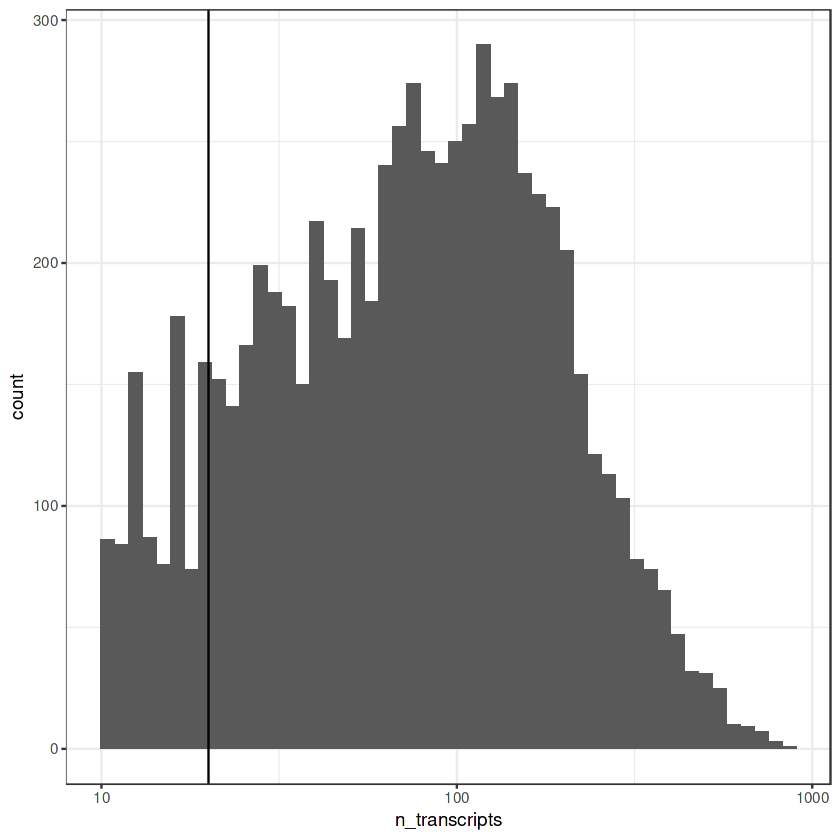

In [5]:
ggplot(so@meta.data) +
  geom_histogram(aes(x=n_transcripts), bins=50) +
  scale_x_log10() +
  geom_vline(xintercept=20)

Normalizing layer: counts

Regressing out nCount_RNA

Centering and scaling data matrix

Computing nearest neighbor graph

Computing SNN

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
05:30:34 UMAP embedding parameters a = 0.9922 b = 1.112

05:30:34 Read 7416 rows and found 30 numeric columns

05:30:34 Using Annoy for neighbor search, n_neighbors = 30

05:30:34 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

05:30:35 Writing NN index file to temp file /tmp/Rtmp0R1Ktu/file3ed72525c29563

05:30:35 Searching Annoy index using 1 thread, 

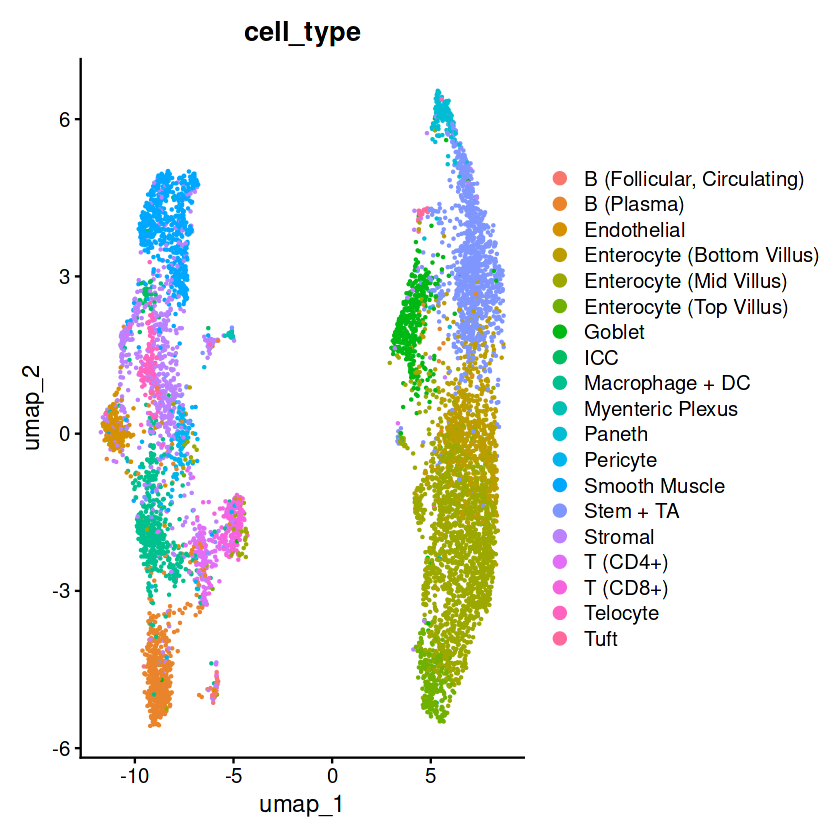

In [6]:
so %<>% NormalizeData() %>% ScaleData(vars.to.regress="nCount_RNA") %>%
  RunPCA(features=rownames(.), verbose=FALSE) %>%
  FindNeighbors(dims=1:30, annoy.metric="cosine") %>%
  RunUMAP(dims=1:30)

DimPlot(so, reduction="umap", group.by="cell_type")

In [7]:
write_rds(so, DatasetPath("mouse_gut", "clustering", "so.rds"))

## scRNA-seq, non-Immune

In [ ]:
cm_rna <- DatasetPath('mouse_gut_rna', 'regional_sampling_UMIcounts.txt') %>%
    read.table(header=TRUE, sep='\t', row.names="GENE", check.names=FALSE) %>%
    .[,2:ncol(.)] %>% as.matrix() %>% as('dgCMatrix')

cell_meta_rna <- DatasetPath('mouse_gut_rna', 'mouse_int_meta.csv') %>%
    read_csv(show_col_types=FALSE) %>%
    filter(Region == 'Ileum') %>%
    select(-Condition, -Region) %>%
    column_to_rownames('NAME') %>%
    rename(cell_type=Cluster)

cm_rna <- cm_rna[, rownames(cell_meta_rna)]

In [ ]:
tic()
so_rna <- cm_rna %>% CreateAssay5Object() %>%
    CreateSeuratObject(meta.data=cell_meta_rna) %>% NormalizeData() %>%
    FindVariableFeatures(selection.method="vst", nfeatures = 2000) %>%
    ScaleData() %>%
    RunPCA(., features=VariableFeatures(.)) %>%
    FindNeighbors(dims=1:30)
toc()
so_rna

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

PC_ 1 
Positive:  Slc51a, Fabp6, Slc51b, St3gal4, Ces2e, Dpep1, Mep1b, Anpep, Prap1, Ccl25 
	   2200002D01Rik, Enpep, Cyp4f14, Cndp2, Lgals3, Reg3b, Slc7a9, Mogat2, Naaladl1, Sult2b1 
	   Muc3, Apoa1, Dgat1, Mep1a, Spink1, Arg2, Reg3a, Fam213b, Slc26a6, Ace2 
Negative:  Spink4, Fxyd3, Agr2, Selm, Muc2, Tff3, Mmp7, Ccl6, Ramp1, Tspan13 
	   Klk1, Tpsg1, Txndc5, Fcgbp, Atoh1, Reep5, Krt18, Hepacam2, Smim6, Nupr1 
	   Smim14, Qsox1, Hpd, Ccl9, Reg4, Tmsb10, Stard10, Slc12a8, Creb3l4, Slc50a1 
PC_ 2 
Positive:  Guca2a, Muc2, Fcgbp, Selm, Tff3, Tpsg1, Lrrc26, Agr2, Klk1, Clca1 
	   Spink4, S100a6, Cgref1, Ccl6, Smim14, Ramp1, Zg16, Scin, Hepacam2, Tspan13 
	   Rep15, Krt20, Txndc5, Atoh1, Pla2g10, Clec2h, Bcas1, Guca2b, Sct, Slc12a8 
Negative:  Clca3b, Tubb5, Tuba1b, Ifitm3, Kcne3, Hmgb2, Cnn3, A

6.965 sec elapsed


An object of class Seurat 
27998 features across 3927 samples within 1 assay 
Active assay: RNA (27998 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 1 dimensional reduction calculated: pca

In [ ]:
tic()
so_rna %<>%
    RunUMAP(dims=1:30, n.epochs=500) %>%
    FindClusters(resolution = 1.5, algorithm=2)
toc()

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
05:09:15 UMAP embedding parameters a = 0.9922 b = 1.112

05:09:15 Read 3927 rows and found 30 numeric columns

05:09:15 Using Annoy for neighbor search, n_neighbors = 30

05:09:15 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

05:09:15 Writing NN index file to temp file /tmp/RtmpVkmYkr/file27063046464ff3

05:09:15 Searching Annoy index using 1 thread, search_k = 3000

05:09:16 Annoy recall = 100%

05:09:16 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3927
Number of edges: 155788

Running Louvain algorithm with multilevel refinement...
Maximum modularity in 10 random starts: 0.7724
Number of communities: 17
Elapsed time: 0 seconds
5.381 sec elapsed


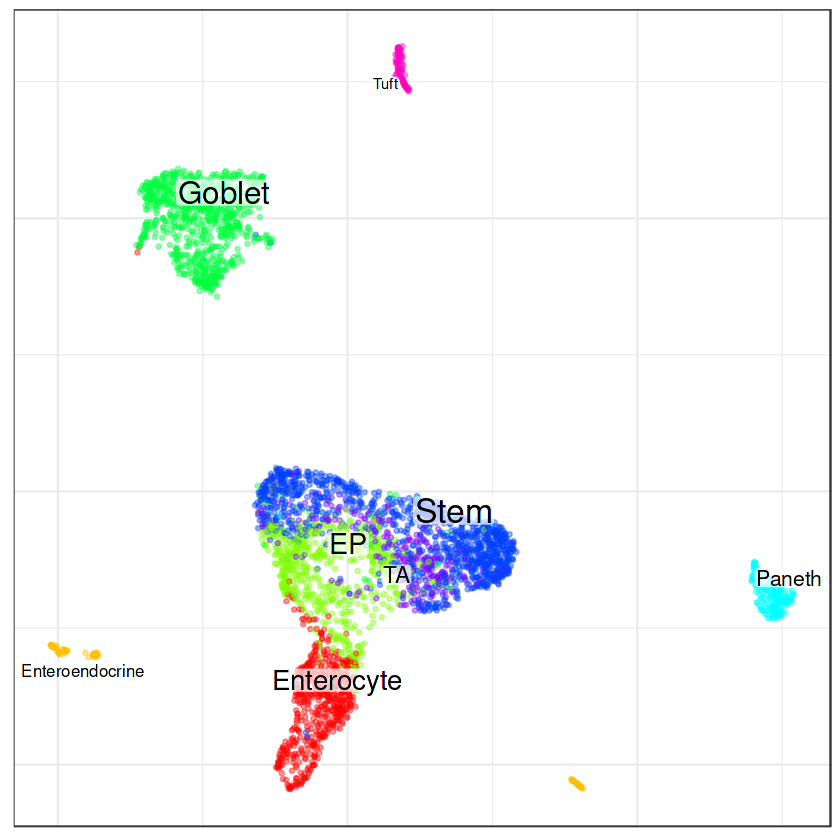

In [ ]:
embeddingPlot(so_rna, reduction='umap', groups='cell_type')

In [ ]:
so_rna$cell_type[so_rna$cell_type %in% c('Stem', 'TA')] <- 'Stem + TA'

In [ ]:
DatasetPath('mouse_gut_rna', 'so.rds') %>% {write_rds(so_rna, .)}

## Marker dotplots

In [ ]:
c_annot <- annotation_rna_adj %>% .[. %in% unique(annotation_spatial)]
markers_rna <- p2_rna$getDifferentialGenes(groups=c_annot, z.threshold=0, append.specificity.metrics=FALSE)
markers_rna <- names(markers_rna) %>% setNames(., .) %>% lapply(\(cn) {
    markers_rna[[cn]][common_genes,] %>% sccore::appendSpecificityMetricsToDE(
        clusters=c_annot, cluster.id=cn, p2.counts=p2_rna$counts, append.auc=TRUE
    )
})

In [ ]:
markers_rna_filt <- markers_rna %>% lapply(\(df) {
    tdf <- df %>% filter(AUC > 0.7, Z > 1)
    if (nrow(tdf) == 0) {
        tdf <- df %>% filter(AUC > 0.6, Z > 1)
    }
    tdf %>% filter(Specificity > 0.8) %>% arrange(-Specificity) %>% head(3)
})

markers_rna_filt %>% sapply(nrow)